In [1]:
from data import DATA_MC3D, DATA_MP

PRODUCTION DATA PRESENT
But cannot retrieve MC3D .xyz structural files because the experimental structures can not be released due to licensing constraints. Using example MP data instead.


In [2]:
from dask.distributed import Client

client = Client()
client

distributed.diskutils - INFO - Found stale lock file and directory '/home/elena/Desktop/R4 - final/r4-project/src/dask-worker-space/worker-o2rpqjam', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/elena/Desktop/R4 - final/r4-project/src/dask-worker-space/worker-x0k3lah9', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/elena/Desktop/R4 - final/r4-project/src/dask-worker-space/worker-pqy5_un4', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/elena/Desktop/R4 - final/r4-project/src/dask-worker-space/worker-_0erh1az', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 7.51 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42145,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.51 GiB
Comm: tcp://127.0.0.1:41125,Total threads: 1
Dashboard: http://127.0.0.1:40721/status,Memory: 1.88 GiB
Nanny: tcp://127.0.0.1:46047,


The geometric.npz file already exists for example data, so we can just import it as follows to create the figures. Otherwise, run the whole notebook. 

## MC3D data analysis

### Load data

In [3]:
import ase.io

frames = ase.io.read(DATA_MC3D.structures, index=":")
# frames = ase.io.read(DATA_MC3D.structures, index="::100")  # DEBUG

In [4]:
from tqdm.auto import tqdm

for frame in tqdm(frames):
    frame.wrap(eps=1e-10)

  0%|          | 0/840 [00:00<?, ?it/s]

100%|██████████| 840/840 [00:00<00:00, 3719.26it/s]


### Compute geometric descriptors

In [5]:
# This cell should only create either delayed objects or perform extremely cheap operations.
import numpy as np
from ase import Atoms
from math import pi
from pymatgen.analysis.local_env import CrystalNN
from tqdm.notebook import tqdm
from utils import get_pymatgen, point_group, get_r as get_radii
import dask.array as da
import dask.bag as db


def compute_cn(frame):
    "Compute the average coordination number."
    cnn = CrystalNN(
        weighted_cn=False,
        distance_cutoffs=None,
        x_diff_weight=0.0,
        porous_adjustment=False,
    )
    pymatgen_frame = get_pymatgen(frame)
    nn = np.empty((len(frame),))
    nn[:] = np.nan
    for i in range(len(frame)):
        nn[i] = cnn.get_cn(pymatgen_frame, i)
    return nn.mean()


def compute_point_group(frame):
    print(type(frame), frame)
    sg = ase.spacegroup.get_spacegroup(frame, symprec=1e-05)
    return point_group(sg.no)


def get_num_species(frame):
    elements = frame.get_chemical_symbols()
    print(elements)
    assert 0
    return len(np.unique(elements))


def compute_x(radii):
    n_s = np.count_nonzero(radii == np.min(radii))
    n_l = np.count_nonzero(radii == np.max(radii))
    return n_s / (n_s + n_l)


db_frames = db.from_sequence(frames, npartitions=len(frames) // 10)

natoms = da.from_array(db_frames.map(len).compute())
magic = np.array((natoms % 4 == 0).compute(), dtype=int)

average_num_nearest_neighbors = db_frames.map(compute_cn)
elements = db_frames.map(lambda frame: frame.get_chemical_symbols())
num_species = elements.map(np.unique).map(len)
radii = elements.map(get_radii)
alpha = radii.map(lambda r: np.min(r) / np.max(r))
std_ratio = radii.map(np.std)
x = radii.map(compute_x)
point_groups = db_frames.map(compute_point_group)
volume_atom = radii.map(lambda r: np.sum((np.pi * 4 / 3) * (np.array(r) / 100) ** 3))
volume = db_frames.map(lambda frame: frame.get_volume())

In [6]:
from dask import compute

if DATA_MC3D.geo.exists():
    print("File already exists, delete it to overwrite!")

else:

    (
        c_magic,
        # c_cn,
        c_num_species,
        c_natoms,
        c_volume_atom,
        c_volume,
        c_alpha,
        c_x,
        c_std_ratio,
        c_point_groups,
    ) = compute(
        magic,
        # average_num_nearest_neighbors,
        num_species,
        natoms,
        volume_atom,
        volume,
        alpha,
        x,
        std_ratio,
        point_groups,
    )

    np.savez(
        DATA_MC3D.geo,
        magic=c_magic,
        # cn=c_cn,
        num_species=c_num_species,
        natoms=c_natoms,
        packing=np.array(c_volume_atom) / np.array(c_volume),
        alpha=c_alpha,
        x=c_x,
        std_ratio=c_std_ratio,
        pg_list=c_point_groups,
    )

File already exists, delete it to overwrite!


In [7]:
import numpy as np
import pandas as pd

fn_parquet = DATA_MC3D.geo.with_suffix(".parquet")

if fn_parquet.exists():
    print("File already exists, delete it to overwrite!")
else:
    npzfile = np.load(DATA_MC3D.geo, allow_pickle=True)
    df = pd.DataFrame({key: npzfile[key] for key in npzfile.keys()})
    df.to_parquet(fn_parquet)

### Generate plots

/tmp/ipykernel_47298/2996709986.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


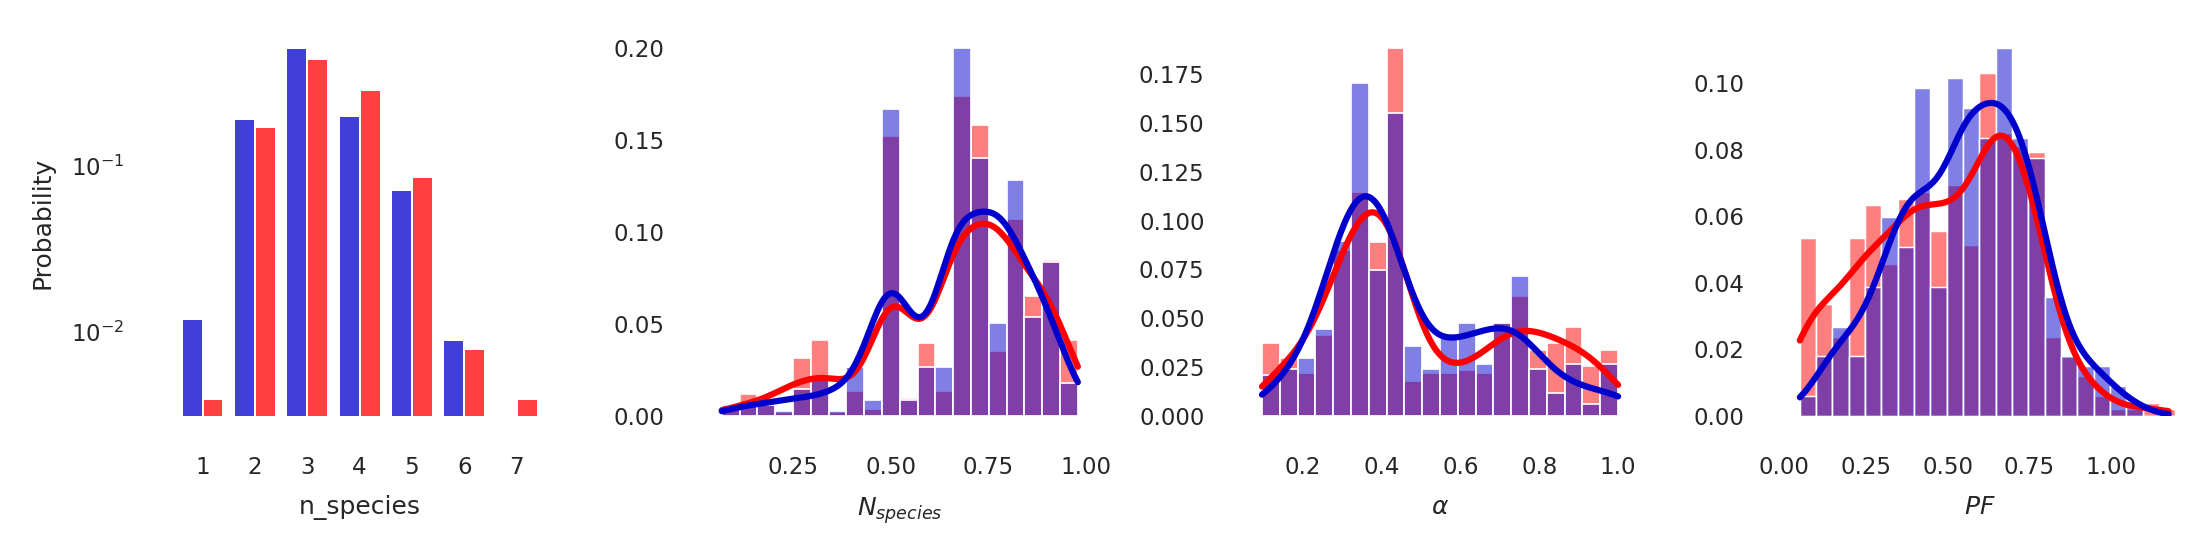

In [17]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colors
from utils import inh_symm

sns.set(style="white", palette="bright", color_codes=True, font_scale=0.5)
my_c = colors.ListedColormap(["mediumblue", "red"])
c = ["mediumblue", "red"]
sns.set_palette(sns.color_palette(c))

df = pd.read_parquet(DATA_MC3D.geo.with_suffix(".parquet")).rename(
    columns={
        "alpha": r"$\alpha$",
        "x": "$x$",
        "std_ratio": r"$\sigma_{radii}$",
        "natoms": r"$N_{atoms,cell}$",
        "packing": r"$PF$",
        "num_species": r"$N_{species}$",
        "pg_list": "point_group",
    },
)

page_width = 530  # pts
inches_per_pt = 1 / 72.27
dpi = 300
fig_width = page_width * inches_per_pt

fig = plt.figure(figsize=(fig_width, fig_width / 4), dpi=dpi)
ax1, ax2, ax3, ax4 = fig.subplots(1, 4)

#   First set of histograms generation
sns.histplot(
    ax=ax1,
    data=df,
    x=r"n_species",
    hue="magic",
    stat="probability",
    legend=False,
    common_norm=False,
    multiple="dodge",
    discrete=True,
    shrink=0.8,
    log_scale=(False, True),
    kde=False,
)
ax1.set_xticks(df["n_species"].unique())
ax2.set_xlabel(r"$N_{species}$")

sns.histplot(
    ax=ax2,
    data=df,
    x=r"$x$",
    hue="magic",
    stat="probability",
    legend=False,
    common_norm=False,
    multiple="layer",
    bins=20,
    kde=True,
)
ax2.set_ylabel(None)

sns.histplot(
    ax=ax3,
    data=df,
    x=r"$\alpha$",
    hue="magic",
    stat="probability",
    legend=False,
    common_norm=False,
    multiple="layer",
    bins=20,
    kde=True,
)
# ax3.set_xlim(0, 1)
ax3.set_ylabel(None)

sns.histplot(
    ax=ax4,
    data=df,
    x=r"$PF$",
    hue="magic",
    stat="probability",
    legend=False,
    common_norm=False,
    multiple="layer",
    binwidth=0.05,
    kde=True,
)
ax4.set_ylabel(None)
ax4.set_xlim(0, 1.2)

sns.despine(left=True, bottom=True)
fig.tight_layout()
fig.show()

fn_out = DATA_MC3D.geo.with_suffix(".pdf")
fig.savefig(fn_out)

In [12]:
df.head()


,magic,cn,n_species,"$N_{atoms,cell}$",fcc,hcp,$PF$,$\alpha$,$x$,$\sigma_{radii}$
0,0.0,12.0,1.0,1.0,0.0,0.0,0.565970,1.000000,0.5,0.0
1,0.0,10.0,1.0,1.0,0.0,0.0,0.696358,1.000000,0.5,0.0
2,0.0,4.0,2.0,2.0,0.0,0.0,0.460447,0.607143,0.5,27.5
3,0.0,6.0,2.0,2.0,1.0,0.0,0.575790,0.571429,0.5,37.5
4,0.0,8.0,2.0,2.0,1.0,0.0,0.642735,0.482759,0.5,37.5


In [ ]:
import seaborn as sns
from matplotlib import colors

from constants import PG_LIST_ORDER
from utils import inh_symm, latexify_hermann_mauguin

sns.set(style="white", palette="bright", color_codes=True, font_scale=0.5)
my_c = colors.ListedColormap(["mediumblue", "red"])
c = ["mediumblue", "red"]
sns.set_palette(sns.color_palette(c))


df = pd.read_parquet(DATA_MC3D.geo.with_suffix(".parquet")).rename(
    columns={
        "pg_list": "point_group",
    },
)

m = df.loc[df["magic"] == 1]
nm = df.loc[df["magic"] == 0]

inh_symm_m = inh_symm(m["point_group"])
inh_symm_nm = inh_symm(nm["point_group"])

inh_symm_m /= inh_symm_m.loc["1"]
inh_symm_nm /= inh_symm_nm.loc["1"]

combined = inh_symm_m.to_frame(name="magic").join(
    inh_symm_nm.to_frame(name="non-magic")
)

fig, ax = plt.subplots(figsize=(fig_width / 2, fig_width / 2), dpi=dpi)
ax = combined.rename(
    index={n: latexify_hermann_mauguin(n) for n in combined.index}
).plot.barh(
    ax=ax,
    color={"magic": "red", "non-magic": "mediumblue"},
    width=0.85,
)
ax.set_xlabel("Proportion of inherited symmetries")
ax.set_ylabel("Point group")
sns.despine(left=True, bottom=True)

fn_out = DATA_MC3D.geo.with_suffix(".inh_symm.pdf")
plt.savefig(fn_out)

## MP data analysis 

In [ ]:
import ase.io
import numpy as np

frames = ase.io.read(DATA_MP.structures, index=":")
# frames = ase.io.read(DATA_MP.structures, index="::100")  # DEBUG

In [ ]:
from tqdm.auto import tqdm

for frame in tqdm(frames):
    frame.wrap(eps=1e-10)

### Compute geometric descriptors

In [ ]:
# This cell should only create either delayed objects or perform extremely cheap operations.
from ase import Atoms
from math import pi
from pymatgen.analysis.local_env import CrystalNN
from tqdm.notebook import tqdm
from utils import get_pymatgen, point_group, get_r as get_radii
import dask.array as da
import dask.bag as db


def compute_cn(frame):
    "Compute the average coordination number."
    cnn = CrystalNN(
        weighted_cn=False,
        distance_cutoffs=None,
        x_diff_weight=0.0,
        porous_adjustment=False,
    )
    pymatgen_frame = get_pymatgen(frame)
    nn = np.empty((len(frame),))
    nn[:] = np.nan
    for i in range(len(frame)):
        nn[i] = cnn.get_cn(pymatgen_frame, i)
    return nn.mean()


def compute_point_group(frame):
    print(type(frame), frame)
    sg = ase.spacegroup.get_spacegroup(frame, symprec=1e-05)
    return point_group(sg.no)


def get_num_species(frame):
    elements = frame.get_chemical_symbols()
    print(elements)
    assert 0
    return len(np.unique(elements))


def compute_x(radii):
    n_s = np.count_nonzero(radii == np.min(radii))
    n_l = np.count_nonzero(radii == np.max(radii))
    return n_s / (n_s + n_l)


db_frames = db.from_sequence(frames, npartitions=len(frames) // 10)

natoms = da.from_array(db_frames.map(len).compute())
magic = np.array((natoms % 4 == 0).compute(), dtype=int)

average_num_nearest_neighbors = db_frames.map(compute_cn)
elements = db_frames.map(lambda frame: frame.get_chemical_symbols())
num_species = elements.map(np.unique).map(len)
radii = elements.map(get_radii)
alpha = radii.map(lambda r: np.min(r) / np.max(r))
std_ratio = radii.map(np.std)
x = radii.map(compute_x)
point_groups = db_frames.map(compute_point_group)
volume_atom = radii.map(lambda r: np.sum((np.pi * 4 / 3) * (np.array(r) / 100) ** 3))
volume = db_frames.map(lambda frame: frame.get_volume())

In [ ]:
from dask import compute


if DATA_MP.geo.exists():
    print("File already exists, delete it to overwrite!")
else:
    (
        c_magic,
        # c_cn,
        c_num_species,
        c_natoms,
        c_volume_atom,
        c_volume,
        c_alpha,
        c_x,
        c_std_ratio,
        c_point_groups,
    ) = compute(
        magic,
        # average_num_nearest_neighbors,
        num_species,
        natoms,
        volume_atom,
        volume,
        alpha,
        x,
        std_ratio,
        point_groups,
    )

    np.savez(
        DATA_MP.geo,
        magic=c_magic,
        # cn=c_cn,
        num_species=c_num_species,
        natoms=c_natoms,
        packing=np.array(c_volume_atom) / np.array(c_volume),
        alpha=c_alpha,
        x=c_x,
        std_ratio=c_std_ratio,
        pg_list=c_point_groups,
    )

In [ ]:
import numpy as np
import pandas as pd

fn_parquet = DATA_MP.geo.with_suffix(".parquet")

if fn_parquet.exists():
    print("File already exists, delete it to overwrite!")
else:
    npzfile = np.load(DATA_MP.geo, allow_pickle=True)
    df = pd.DataFrame({key: npzfile[key] for key in npzfile.keys()})
    df.to_parquet(fn_parquet)

### Generate plots

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colors
from utils import inh_symm

sns.set(style="white", palette="bright", color_codes=True, font_scale=0.5)
my_c = colors.ListedColormap(["mediumblue", "red"])
c = ["mediumblue", "red"]
sns.set_palette(sns.color_palette(c))

df = pd.read_parquet(DATA_MP.geo.with_suffix(".parquet")).rename(
    columns={
        "alpha": r"$\alpha$",
        "x": "$x$",
        "std_ratio": r"$\sigma_{radii}$",
        "natoms": r"$N_{atoms,cell}$",
        "packing": r"$PF$",
        "num_species": r"$N_{species}$",
        "pg_list": "point_group",
    },
)

page_width = 530  # pts
inches_per_pt = 1 / 72.27
dpi = 300
fig_width = page_width * inches_per_pt

fig = plt.figure(figsize=(fig_width, fig_width / 4), dpi=dpi)
ax1, ax2, ax3, ax4 = fig.subplots(1, 4)

#   First set of histograms generation
sns.histplot(
    ax=ax1,
    data=df,
    x=r"$N_{species}$",
    hue="magic",
    stat="probability",
    legend=False,
    common_norm=False,
    multiple="dodge",
    discrete=True,
    shrink=0.8,
    log_scale=(False, True),
    kde=False,
)
ax1.set_xticks(df["$N_{species}$"].unique())

sns.histplot(
    ax=ax2,
    data=df,
    x=r"$x$",
    hue="magic",
    stat="probability",
    legend=False,
    common_norm=False,
    multiple="layer",
    bins=20,
    kde=True,
)
ax2.set_ylabel(None)

sns.histplot(
    ax=ax3,
    data=df,
    x=r"$\alpha$",
    hue="magic",
    stat="probability",
    legend=False,
    common_norm=False,
    multiple="layer",
    bins=20,
    kde=True,
)
# ax3.set_xlim(0, 1)
ax3.set_ylabel(None)

sns.histplot(
    ax=ax4,
    data=df,
    x=r"$PF$",
    hue="magic",
    stat="probability",
    legend=False,
    common_norm=False,
    multiple="layer",
    # bins=20,
    binwidth=0.05,
    kde=True,
)
ax4.set_ylabel(None)
ax4.set_xlim(0, 1.2)

sns.despine(left=True, bottom=True)
fig.tight_layout()
fig.show()

fn_out = DATA_MP.geo.with_suffix(".pdf")
fig.savefig(fn_out)

In [ ]:
import seaborn as sns
from matplotlib import colors

from constants import PG_LIST_ORDER
from utils import inh_symm, latexify_hermann_mauguin

sns.set(style="white", palette="bright", color_codes=True, font_scale=0.5)
my_c = colors.ListedColormap(["mediumblue", "red"])
c = ["mediumblue", "red"]
sns.set_palette(sns.color_palette(c))


df = pd.read_parquet(DATA_MP.geo.with_suffix(".parquet")).rename(
    columns={
        "pg_list": "point_group",
    },
)

m = df.loc[df["magic"] == 1]
nm = df.loc[df["magic"] == 0]

inh_symm_m = inh_symm(m["point_group"])
inh_symm_nm = inh_symm(nm["point_group"])

inh_symm_m /= inh_symm_m.loc["1"]
inh_symm_nm /= inh_symm_nm.loc["1"]

combined = inh_symm_m.to_frame(name="magic").join(
    inh_symm_nm.to_frame(name="non-magic")
)

fig, ax = plt.subplots(figsize=(fig_width / 2, fig_width / 2), dpi=dpi)
combined.rename(
    index={n: latexify_hermann_mauguin(n) for n in combined.index}
).plot.barh(
    ax=ax,
    color={"magic": "red", "non-magic": "mediumblue"},
    width=0.85,
)

ax.set_xlabel("Proportion of inherited symmetries")
ax.set_ylabel("Point group")
sns.despine(left=True, bottom=True)

fn_out = DATA_MP.geo.with_suffix(".inh_symm.pdf")
plt.savefig(fn_out)